In [ ]:
#!pip install transformers datasets pandas pyarrow scikit-learn torch
!pip install datasets
#imports
import pandas as pd
import sys
import sklearn
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from datasets import load_dataset

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
import numpy as np
import os

# For figures
import matplotlib as mpl
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["test"])

In [ ]:
df_train.head()


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [ ]:
#Perceptron Imports
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from transformers import BertTokenizer
from datasets import Dataset

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(df_train[['text', 'label']])
test_dataset = Dataset.from_pandas(df_test[['text', 'label']])

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

#BERT IMPLEMENTATION


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Metrics
def compute_metrics(pred):
    logits, labels = pred
    predictions = torch.argmax(torch.tensor(logits), axis=1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

# Save model
model.save_pretrained("bert-imdb-custom-parquet")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mcnult48 (mcnult48-michigan-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.278600,0.258668,0.918640,0.915644,0.950654,0.883120
2,0.165100,0.246960,0.934200,0.934329,0.932505,0.936160
3,0.065300,0.339493,0.936720,0.936967,0.933323,0.940640


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

# Run prediction on the test set
preds_output = trainer.predict(test_dataset)

# Get true labels and predicted labels
y_true = preds_output.label_ids
y_pred = torch.argmax(torch.tensor(preds_output.predictions), axis=1).numpy()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

# Print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


NameError: name 'trainer' is not defined

In [ ]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits).item()
    return "Positive" if prediction == 1 else "Negative"

# Test
print(predict_sentiment("Absolutely stunning film!"))
print(predict_sentiment("Worst acting I've ever seen."))


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

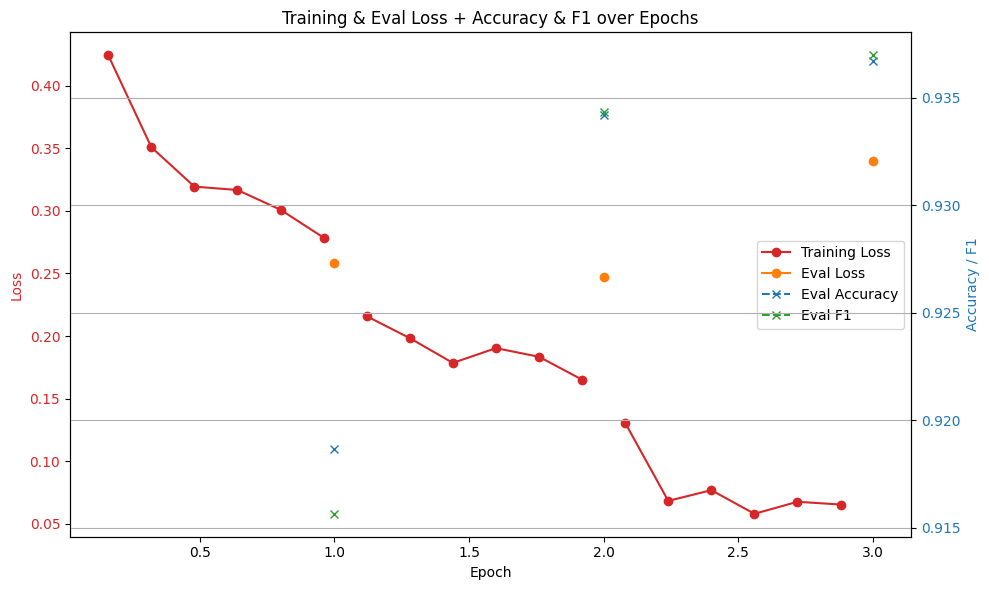

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract and clean log data
log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)

# Filter for needed metrics
train_loss = df_logs[df_logs["loss"].notnull()][["epoch", "loss"]]
eval_metrics = df_logs[df_logs["eval_loss"].notnull()][["epoch", "eval_loss", "eval_accuracy", "eval_f1"]]

# Merge by epoch (this will align them nicely)
combined = pd.merge(train_loss, eval_metrics, on="epoch", how="outer")

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left Y-axis for loss
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(combined["epoch"], combined["loss"], label="Training Loss", color="tab:red", marker="o")
ax1.plot(combined["epoch"], combined["eval_loss"], label="Eval Loss", color="tab:orange", marker="o")
ax1.tick_params(axis='y', labelcolor="tab:red")

# Right Y-axis for accuracy and F1
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy / F1", color="tab:blue")
ax2.plot(combined["epoch"], combined["eval_accuracy"], label="Eval Accuracy", color="tab:blue", linestyle="--", marker="x")
ax2.plot(combined["epoch"], combined["eval_f1"], label="Eval F1", color="tab:green", linestyle="--", marker="x")
ax2.tick_params(axis='y', labelcolor="tab:blue")

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

plt.title("Training & Eval Loss + Accuracy & F1 over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()



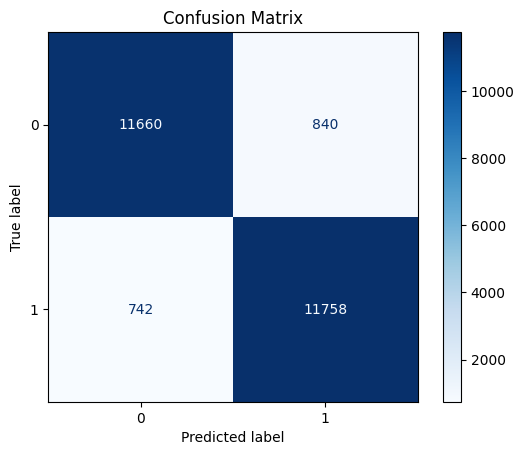

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_output = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(preds_output.predictions), axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


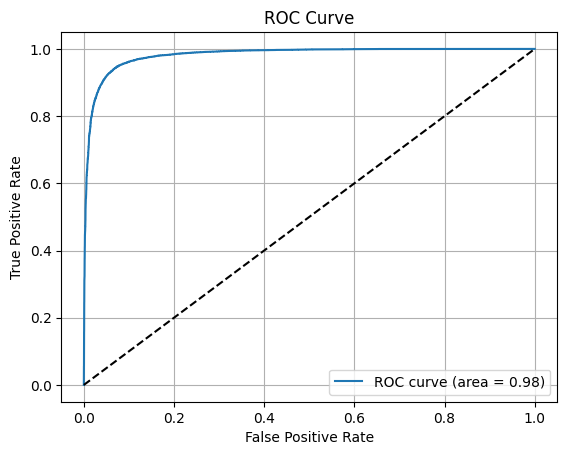

In [ ]:
from sklearn.metrics import roc_curve, auc

probs = torch.softmax(torch.tensor(preds_output.predictions), dim=1)[:, 1]
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # random line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
